In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

import graph_tools
import graph_gen

import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [15]:
num_nodes = 500

times = []
x = []

logger, handler = logger_creator.create_logger("benchmarking")

dense_graph = nx.gnp_random_graph(num_nodes, p=0.50, directed=True)
dense_graph = graph_tools.nx_graph_nodes_to_str(dense_graph)
delegation_graph = graph_tools.prepare_graph(dense_graph.nodes(), dense_graph.edges(), sink_frac = 0.1)
delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)

delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(delegation_graph)

# Verify the solutions are equal
powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
powers_iter = iterative.iterate_delegations(delegations, nodes)

if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
    logger.error("Powers do not match")
    logger.error(f"LE: {powers_le}")
    logger.error(f"LP: {powers_lp}")
    print("Mismatching powers in LE and LP. Check the log file for details.")

for node in sinks_le:
    if (powers_lp[node] - powers_iter[node] < 0.01):
        continue
    else: 
        logger.error("Powers do not match")
        logger.error(f"LP: {powers_lp}")
        logger.error(f"Iterative: {powers_iter}")
        print("Mismatching powers in LP and Iterative. Check the log file for details.")
        break

for i in range(11):
    precision = 10**(-i)
    x.append(i)
    print(precision)

    n = 5
    print("here")

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes, cutoff=precision)
    end_time = time.time()

    times.append((end_time - start_time) / n)

logger.removeHandler(handler)
handler.close()

1
here
0.1
here
0.01
here
0.001
here
0.0001
here
1e-05
here
1e-06
here
1e-07
here
1e-08
here
1e-09
here
1e-10
here


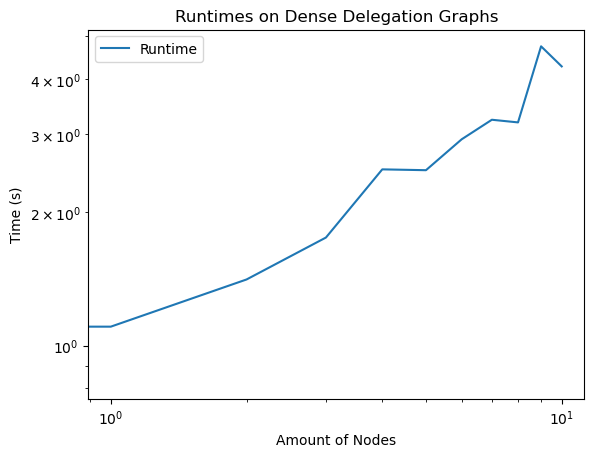

In [20]:
plt.clf()

iterations = [59, 81, 103, 124, 146, 168, 190, 211, 233, 255, 276]
plt.plot(x, times, label=f"Runtime")
#plt.plot(x, iterations, label="Iterations", linestyle='--')

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Dense Delegation Graphs")
plt.xscale('log')
plt.yscale('log')
plt.show()